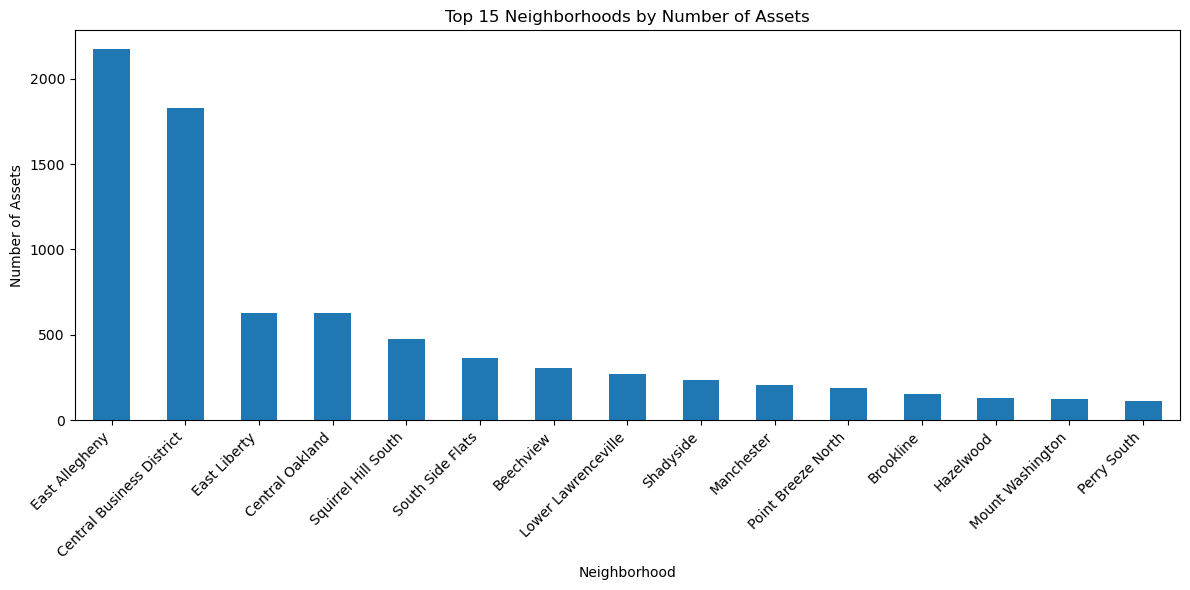

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
assets = pd.read_csv("Assets.csv", low_memory=False)
city = pd.read_csv("CityOwnedProperties.csv", low_memory=False)
zip_tract = pd.read_csv("ZIP_TRACT_032020.csv", low_memory=False)
assets_zip = assets.dropna(subset=["zip_code"]).copy()
assets_zip["zip5"] = assets_zip["zip_code"].astype(str).str.extract(r"(\d{5})")[0]
assets_zip = assets_zip.dropna(subset=["zip5"])
assets_zip["zip_int"] = assets_zip["zip5"].astype(int)
zip_tract = zip_tract.dropna(subset=["ZIP", "TRACT"]).copy()
zip_tract["ZIP_int"] = zip_tract["ZIP"].astype(int)
zip_tract["TRACT_int"] = zip_tract["TRACT"].astype("int64")
zip_primary = (
    zip_tract.sort_values("TOT_RATIO", ascending=False)
             .drop_duplicates("ZIP_int")[["ZIP_int", "TRACT_int"]]
)
city_tt = city.dropna(subset=["census_tract", "neighborhood_name"]).copy()
city_tt["census_tract_int"] = city_tt["census_tract"].astype("int64")
tract_to_hood = (
    city_tt.groupby("census_tract_int")["neighborhood_name"]
           .agg(lambda s: s.value_counts().idxmax())
           .reset_index()
)
zip_to_hood = zip_primary.merge(
    tract_to_hood,
    left_on="TRACT_int",
    right_on="census_tract_int",
    how="inner"
)
assets_with_hood = assets_zip.merge(
    zip_to_hood[["ZIP_int", "neighborhood_name"]],
    left_on="zip_int",
    right_on="ZIP_int",
    how="left"
)
assets_per_neighborhood = (
    assets_with_hood
    .dropna(subset=["neighborhood_name"])
    .groupby("neighborhood_name")["asset_id"]
    .count()
    .sort_values(ascending=False)
)
top_n = 15
plt.figure(figsize=(12, 6))
assets_per_neighborhood.head(top_n).plot(kind="bar")
plt.title(f"Top {top_n} Neighborhoods by Number of Assets")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Assets")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


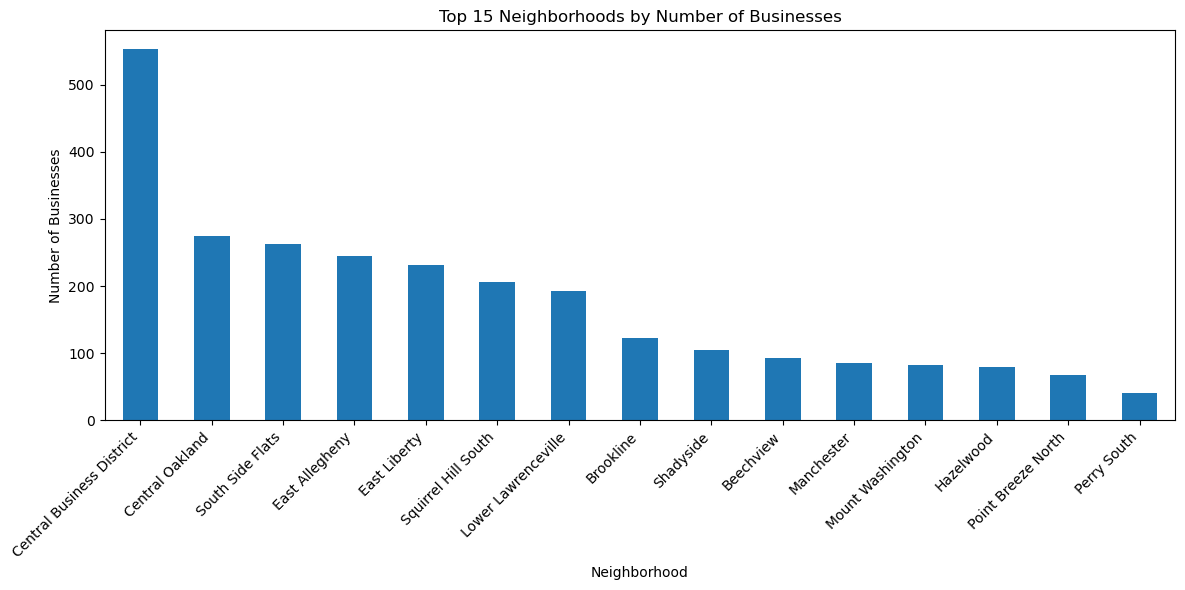

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

business = pd.read_csv("Buisness's.csv", low_memory=False)
city = pd.read_csv("CityOwnedProperties.csv", low_memory=False)
zip_tract = pd.read_csv("ZIP_TRACT_032020.csv", low_memory=False)

business["zip5"] = business["address"].astype(str).str.extract(r"(\d{5})")
business = business.dropna(subset=["zip5"])
business["zip_int"] = business["zip5"].astype(int)

zip_tract = zip_tract.dropna(subset=["ZIP", "TRACT"]).copy()
zip_tract["ZIP_int"] = zip_tract["ZIP"].astype(int)
zip_tract["TRACT_int"] = zip_tract["TRACT"].astype("int64")

zip_primary = (
    zip_tract.sort_values("TOT_RATIO", ascending=False)
             .drop_duplicates("ZIP_int")[["ZIP_int", "TRACT_int"]]
)

city_ct = city.dropna(subset=["census_tract", "neighborhood_name"]).copy()
city_ct["census_tract_int"] = city_ct["census_tract"].astype("int64")

tract_to_hood = (
    city_ct.groupby("census_tract_int")["neighborhood_name"]
           .agg(lambda s: s.value_counts().idxmax())
           .reset_index()
)

zip_to_hood = zip_primary.merge(
    tract_to_hood,
    left_on="TRACT_int",
    right_on="census_tract_int",
    how="inner"
)

business_with_hood = business.merge(
    zip_to_hood[["ZIP_int", "neighborhood_name"]],
    left_on="zip_int",
    right_on="ZIP_int",
    how="left"
)

business_counts = (
    business_with_hood
    .dropna(subset=["neighborhood_name"])
    .groupby("neighborhood_name")["business_name"]
    .nunique()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12, 6))
business_counts.head(15).plot(kind="bar")
plt.title("Top 15 Neighborhoods by Number of Businesses")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Businesses")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

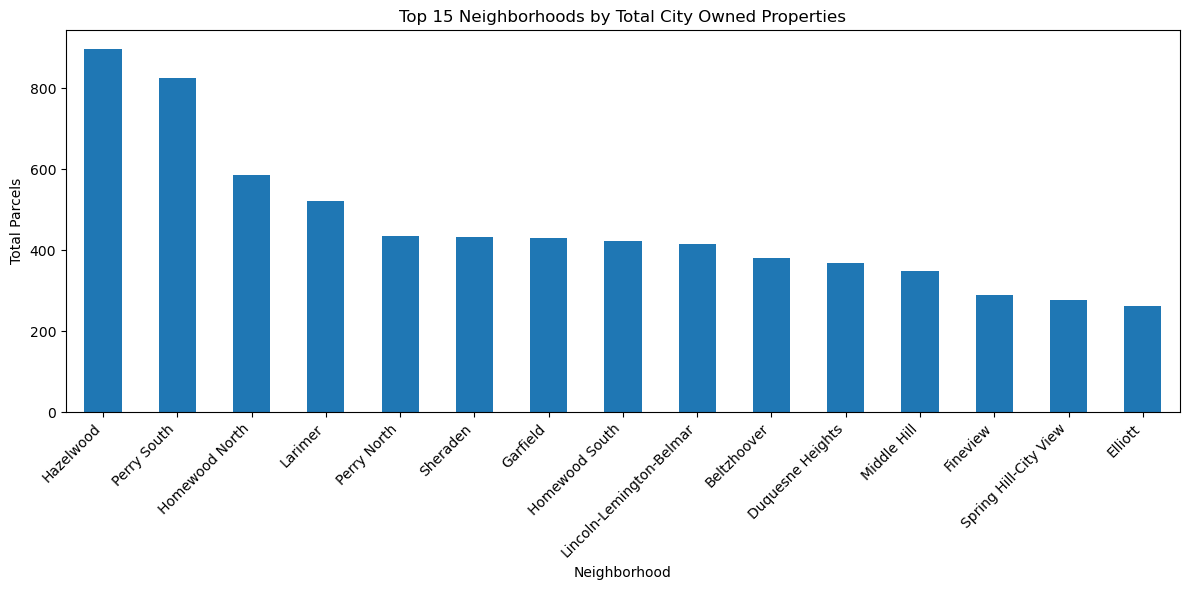

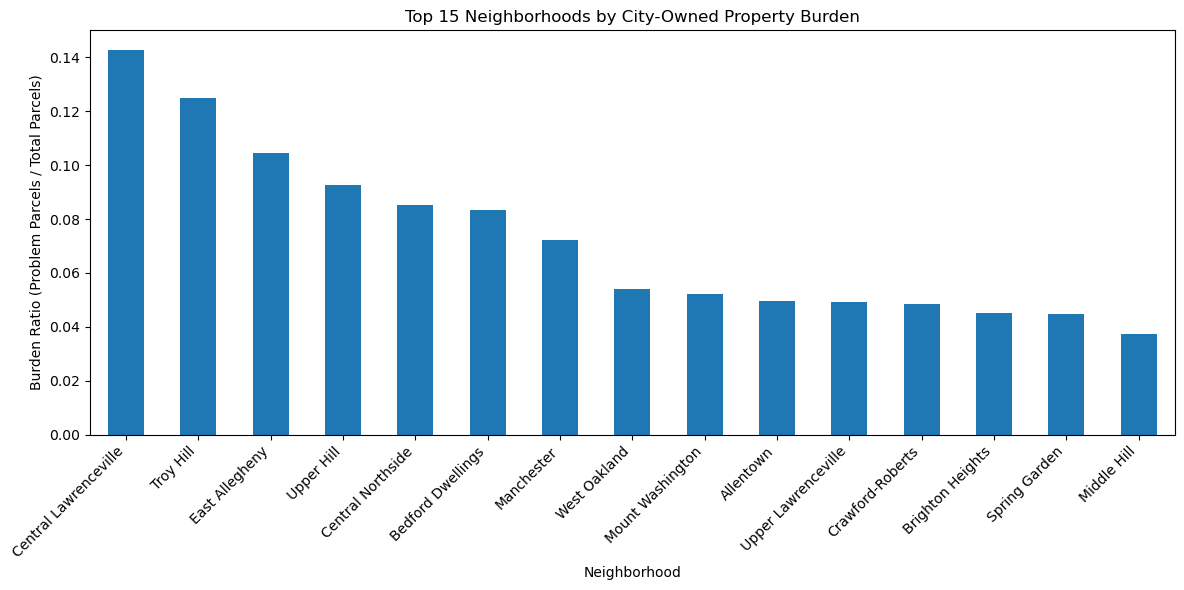

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

city = pd.read_csv("CityOwnedProperties.csv", low_memory=False)
city = city.dropna(subset=["neighborhood_name"])

problem_mask = (
    city["inventory_type"].str.contains("Vacant|Surplus|Sideyard|Reserve", case=False, na=False)
    | city["current_status"].str.contains("Vacant|Demolition|Abandoned", case=False, na=False)
)

city["is_problem"] = problem_mask

city_grouped = (
    city.groupby("neighborhood_name")
    .agg(
        total_parcels=("pin", "count"),
        problem_parcels=("is_problem", "sum")
    )
)

city_grouped["burden_ratio"] = city_grouped["problem_parcels"] / city_grouped["total_parcels"]
city_grouped_sorted = city_grouped.sort_values("total_parcels", ascending=False)

plt.figure(figsize=(12, 6))
city_grouped_sorted.head(15)["total_parcels"].plot(kind="bar")
plt.title("Top 15 Neighborhoods by Total City Owned Properties")
plt.xlabel("Neighborhood")
plt.ylabel("Total Parcels")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

burden_sorted = city_grouped.sort_values("burden_ratio", ascending=False)

plt.figure(figsize=(12, 6))
burden_sorted.head(15)["burden_ratio"].plot(kind="bar")
plt.title("Top 15 Neighborhoods by City-Owned Property Burden")
plt.xlabel("Neighborhood")
plt.ylabel("Burden Ratio (Problem Parcels / Total Parcels)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show() 